# Проект для «Викишоп» с **BERT**

****

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

## Описание проекта

Задача классификации - определить относится ли комментарий к токсичному.

Итоговоя метрика задана в условиях задачи - F1 не менее 75.

Функция потерь - logloss.

Будем использовать CatBoost и bert

Для предсказаний каждой модели подберем threshold в цикле в диапазоне 0-1.



### Загрузка данных и библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

! pip install detoxify -q
# bert
from detoxify import Detoxify

! pip install catboost -q
from catboost import CatBoostClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data = pd.read_csv('/datasets/toxic_comments.csv')
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/ПРОЕКТЫ/toxic_comments/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


- В данных содержится 159292 объекта
- 2 признака text и toxic
- пропуски отсутствуют
- тип данных object для признака text
- тип данных int для целевого признака toxic

In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.columns

Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')

Удалим лишние столбцы Unnamed, 0

In [ ]:
data.drop('Unnamed: 0', axis = 1, inplace=True)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Видим, что текст:
- на английском языке
- не лемматизирован
- не токенизирован
- Нуждается в очистке от лишних символов и стоп слов.


Для обработки текста будем использовать библиотеку NLTK(лемматизация, токенизация, стоп_слова).
Для очистки от символов библиотека Re.

### Обработка текста

In [ ]:
# создадим переменную которую будем обрабатывать
corpus = data.copy()

In [ ]:
# проверим работу
word_tokens = corpus['text'].iloc[:5].apply(lambda x: word_tokenize(x))
word_tokens

0    [Explanation, Why, the, edits, made, under, my...
1    [D'aww, !, He, matches, this, background, colo...
2    [Hey, man, ,, I, 'm, really, not, trying, to, ...
3    [``, More, I, ca, n't, make, any, real, sugges...
4    [You, ,, sir, ,, are, my, hero, ., Any, chance...
Name: text, dtype: object


Чтобы удалить стоп_слова из наших данных напишем функцию, которая на вход примет список слов и вернет новый список из слов, которых нет в stop_words и приведенных к нижнему регистру.

Далее эту функцию применим к объекту pandas.dataframe

In [ ]:
def clean_stop_words (list_words):
  # стоп_слова
  stop_words = set(stopwords.words('english'))

  return [w.lower() for w in list_words if w not in stop_words]

In [ ]:
# проверим работу
print(f'''
Длина строки до очистки: {len(word_tokens[0])}

Длина строки после очистки: {len(word_tokens.apply(lambda x: clean_stop_words(x))[0])}''')


Длина строки до очистки: 49

Длина строки после очистки: 35


Функция работает как и ожидалось, применим ее к нашему тексту

In [ ]:
word_stop_words = word_tokens.copy().apply(lambda x: clean_stop_words (x))
word_stop_words

0    [explanation, why, edits, made, username, hard...
1    [d'aww, !, he, matches, background, colour, i,...
2    [hey, man, ,, i, 'm, really, trying, edit, war...
3    [``, more, i, ca, n't, make, real, suggestions...
4    [you, ,, sir, ,, hero, ., any, chance, remembe...
Name: text, dtype: object

Теперь можно применить очисту от символов

In [ ]:
def clean_symb(list):
  # обозначаем символы, которые должны остаться, латинский алфавит
  reg = re.compile('[^a-zA-Z\']')
  return [reg.sub('', sent)  for sent in list]

In [ ]:
word_cleaned = word_stop_words.apply(lambda x: clean_symb(x))
word_cleaned

0    [explanation, why, edits, made, username, hard...
1    [d'aww, , he, matches, background, colour, i, ...
2    [hey, man, , i, 'm, really, trying, edit, war,...
3    [, more, i, ca, n't, make, real, suggestions, ...
4    [you, , sir, , hero, , any, chance, remember, ...
Name: text, dtype: object

Текст очищен от символов верно, далее лемматизируем очищенный текст

In [ ]:
def lemmatize_text(list):
  # инициируем лемматайзер
  wnl = WordNetLemmatizer()
  return [wnl.lemmatize(word) for word in list]

In [ ]:
# проверим работу функции
print(f'''
Текст до лемматизации: {word_cleaned}

Текст после лемматизации: {word_cleaned.apply(lambda x: lemmatize_text(x))}''')



Текст до лемматизации: 0    [explanation, why, edits, made, username, hard...
1    [d'aww, , he, matches, background, colour, i, ...
2    [hey, man, , i, 'm, really, trying, edit, war,...
3    [, more, i, ca, n't, make, real, suggestions, ...
4    [you, , sir, , hero, , any, chance, remember, ...
Name: text, dtype: object

Текст после лемматизации: 0    [explanation, why, edits, made, username, hard...
1    [d'aww, , he, match, background, colour, i, 'm...
2    [hey, man, , i, 'm, really, trying, edit, war,...
3    [, more, i, ca, n't, make, real, suggestion, i...
4    [you, , sir, , hero, , any, chance, remember, ...
Name: text, dtype: object


функция работает ожидаемо. Теперь соберем все шаги по обработке текста в единую функцию и применим ко всему датасету.

In [ ]:
def processing_text(text):
   # text представлен в формате dataframe

  # сначала токенизируем

  text_tokenized = text.apply(lambda x: word_tokenize(x))

  # чистим от стоп слов
  text_stop_words = text_tokenized.apply(lambda x: clean_stop_words(x))

  # очищаем от символов
  text_smbl =  text_stop_words.apply(lambda x: clean_symb(x))

  # лемматизируем
  text_lemmatized = text_smbl.apply(lambda x: lemmatize_text(x))

  return text_lemmatized

In [ ]:
# проверяем работу функции
processing_text(corpus['text'].iloc[:5])

0    [explanation, why, edits, made, username, hard...
1    [d'aww, , he, match, background, colour, i, 'm...
2    [hey, man, , i, 'm, really, trying, edit, war,...
3    [, more, i, ca, n't, make, real, suggestion, i...
4    [you, , sir, , hero, , any, chance, remember, ...
Name: text, dtype: object

In [ ]:
%%time
corpus['text'] = processing_text(corpus['text'])

CPU times: user 2min 31s, sys: 3.59 s, total: 2min 35s
Wall time: 2min 36s


In [ ]:
corpus['text'] = corpus['text'].astype('str')

## Машинное обучение

In [ ]:
# оценим баланс классов перед разделением выборки
corpus[['toxic']].value_counts(normalize = True)

toxic
0        0.898388
1        0.101612
Name: proportion, dtype: float64

В данных 10% токсичных коментариев, выборку нужно делить с учетом дисбаланса

In [ ]:
train, test = train_test_split(corpus,
                               shuffle = True,
                               random_state=42,
                               stratify = corpus['toxic'],
                               test_size = 0.1)

train, valid = train_test_split(train,
                              shuffle = True,
                              random_state=42,
                              stratify = train['toxic'],
                              test_size = 0.1)

In [ ]:
print (f'''
Обучающая выборка {train.shape}

Тетовая выборка {valid.shape}

Тестовая выборка {test.shape}''')


Обучающая выборка (129025, 2)

Тетовая выборка (14337, 2)

Тестовая выборка (15930, 2)


Выборки поделены верно

### CatBoost

In [ ]:
X = ['text']
text_features = ['text']
y = ['toxic']

In [ ]:
params = {'eval_metric':'AUC',
          'learning_rate': 0.06,
          'text_features': text_features,
          'task_type':'GPU',
          'verbose':100}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train[X],train[y],
          eval_set=(valid[X],valid[y]))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8985153	best: 0.8985153 (0)	total: 38.1ms	remaining: 38.1s
100:	test: 0.9598227	best: 0.9598227 (100)	total: 1.37s	remaining: 12.2s
200:	test: 0.9632052	best: 0.9632052 (200)	total: 2.61s	remaining: 10.4s
300:	test: 0.9645245	best: 0.9645245 (300)	total: 5.55s	remaining: 12.9s
400:	test: 0.9653007	best: 0.9653007 (400)	total: 7.2s	remaining: 10.8s
500:	test: 0.9658545	best: 0.9658842 (495)	total: 8.39s	remaining: 8.35s
600:	test: 0.9663094	best: 0.9663163 (595)	total: 9.56s	remaining: 6.35s
700:	test: 0.9666291	best: 0.9666463 (695)	total: 10.8s	remaining: 4.59s
800:	test: 0.9667964	best: 0.9667964 (800)	total: 11.9s	remaining: 2.97s
900:	test: 0.9669957	best: 0.9669957 (900)	total: 13.1s	remaining: 1.44s
999:	test: 0.9672877	best: 0.9673230 (985)	total: 14.3s	remaining: 0us
bestTest = 0.9673229754
bestIteration = 985
Shrink model to first 986 iterations.


In [ ]:
valid['y_score'] = model.predict_proba(valid[X])[:,1]

In [ ]:
# найдем лучший порог для отнесения комментария к 1 классу
res = []

for thr in tqdm(np.linspace(0,1,101)):

  res.append((thr,f1_score(valid[y].astype('int'), valid['y_score'] > thr)))


  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
df_f1 = pd.DataFrame(res,columns=['thr','f1'])
df_f1.sort_values('f1',ascending=False)

,thr,f1
46,0.46,0.781423
40,0.40,0.780036
35,0.35,0.780034
43,0.43,0.780029
47,0.47,0.779711
...,...,...
2,0.02,0.400901
99,0.99,0.369214
1,0.01,0.286878
0,0.00,0.184500


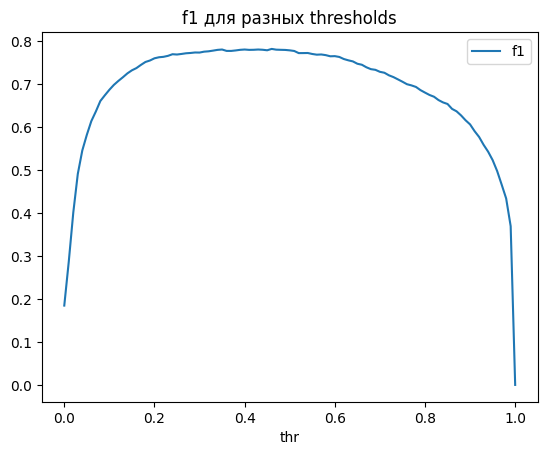

In [ ]:
# визуализируем результат
df_f1.set_index('thr').plot()
plt.title('f1 для разных thresholds')
plt.show()

На графике мы видим, что максимальное значение метрики f1 достигается в районе 0.45 - 0.5

Метрика f1 достигает на тесте минимально необходимого значения.

### BERT

Будем использовать предобученную модель Detoxify для получения предсказаний на валидационной выборке

In [ ]:
bert_model = Detoxify('original', device=device)

y_score_bert = []

for txt in tqdm(list(valid['text'].values)):
  y_score_bert.append(bert_model.predict(txt)['toxicity'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/14337 [00:00<?, ?it/s]

In [ ]:
valid['y_score_bert'] = y_score_bert

In [ ]:
# найдем лучший порог thr для отнесения к 1 классу
res = []
for thr in tqdm(np.linspace(0,1,101)):
  res.append((thr,f1_score(valid[y].astype('int'), valid['y_score_bert'] > thr)))


  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
df2_f1 = pd.DataFrame(res,columns=['thr','f1'])
df2_f1.sort_values('f1',ascending=False)

,thr,f1
7,0.07,0.808629
6,0.06,0.806244
8,0.08,0.806054
9,0.09,0.805139
10,0.10,0.803047
...,...,...
97,0.97,0.328170
98,0.98,0.287897
99,0.99,0.211172
0,0.00,0.184500


In [ ]:
# сохраним лучший трешхолд в переменную
thr = 0.07

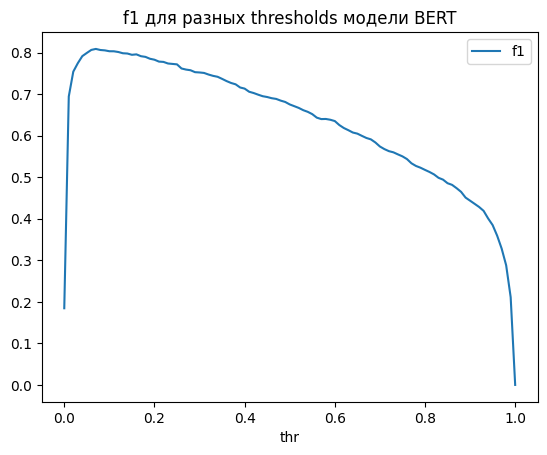

In [ ]:
# визуализируем
df2_f1.set_index('thr').plot()
plt.title('f1 для разных thresholds модели BERT')
plt.show()

In [ ]:
df2_f1.to_csv('df2_f1.csv')

In [ ]:
valid.to_csv('valid.csv')

# Сравнение работы двух моделей и итоговое тестирование

Отобразим f1 и thr обеих моделей на одном графике

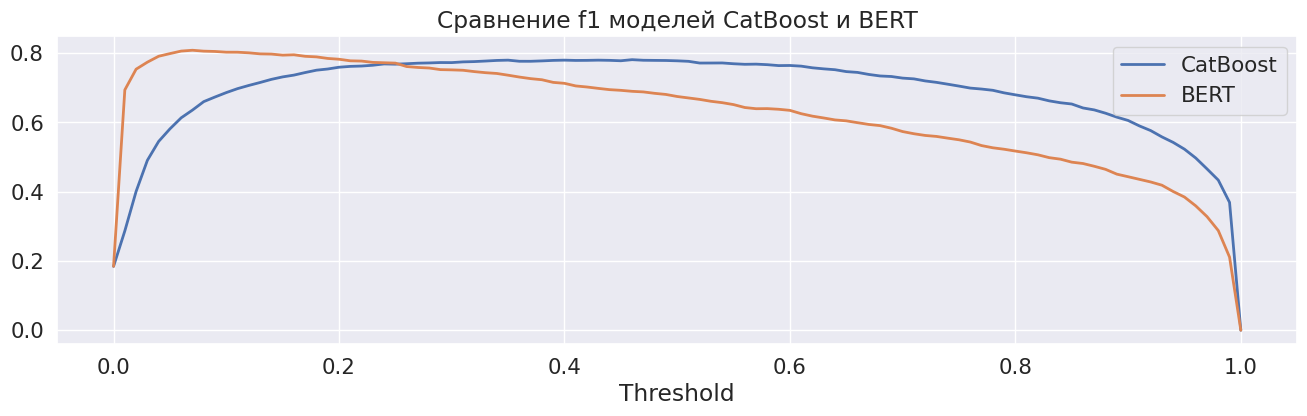

In [ ]:
#  визуализируем результат работы обеих моделей
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 4))
plt.title("Сравнение f1 моделей CatBoost и BERT")
plt.plot(df_f1['thr'], df_f1['f1'], label="CatBoost", linewidth=2)
plt.plot(df2_f1['thr'], df2_f1['f1'], label="BERT", linewidth=2)
plt.legend()
plt.xlabel("Threshold")
plt.show()

Как видим, предсказания bert оказались точнее, хоть и не существенно (0.78 catboost 0.8 bert).

Но у моделей существенно отличаются thresholds для отнесения к 1 классу.

Время работы на gpu у обоих моделей сопостовимо, поэтому будем использовать модель bert, показавшую лучший результат на валидационной выборке.

In [ ]:
y_score_test = []

for txt in tqdm(list(test['text'].values)):
  y_score_test.append(bert_model.predict(txt)['toxicity'])

  0%|          | 0/15930 [00:00<?, ?it/s]

In [ ]:
test['y_score'] = y_score_test

In [ ]:
# получим метрику f1 score на тестовой выборке с лучшим порогом
f1_test = f1_score(test['toxic'].astype('int'), test['y_score'] > thr)
f1_test

0.8251659816629783

# Вывод

В ходе работы по предсказанию токсичности комментариев, мной были исследованы данные:
159292 объекта с коментариями.
Данные содержали  2 признака text и toxic.

Пропуски отсутствовали, тип данных:
- тип данных object для признака text
- тип данных int для целевого признака toxic

Данные были предобработаны в следующем объеме:
- токенизация при помощи библиотеки nltk
- удаление символов при помощи библиотеки re
- удаление стоп_слов при помощи библиотеки nltk
- лемматизация при помощи библиотеки nltk.

По итогу выбора модели были исследованы 2 модели:
- Catboost
- BERT
По итогам обе модели показали удовлетворительный результа метрики f1:

|         |   f1     |   thr |    
|---------|----------|-------|
|CatBoost |0.781423  |  0.46 |    
|BERT     |0.808629  |  0.07 |
|test|    |0.825166  |  0.07 |

У модели bert очень низкий порог отнесений комментария к токсичным - 0.07 для валидации и для теста.